In [83]:
from lightgbm import LGBMRegressor,LGBMClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from xgboost import XGBRegressor,XGBClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import mean_squared_error,f1_score,precision_score,recall_score

from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.feature_selection import RFE


from boruta import BorutaPy
from sklearnex import patch_sklearn,unpatch_sklearn

from group_lasso import LogisticGroupLasso
np.random.seed(0)
LogisticGroupLasso.LOG_LOSSES = True

from scipy.stats import f_oneway, chi2_contingency

from copy import deepcopy

import gc
import pickle

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

from Interaction_effect_features import get_data

from MetaHeuristics import FeatureSelection

from sklearn.utils import check_random_state

# from EvolutionaryFS import GeneticAlgorithmFS
# from SimmulatedAnnealingFS import SimulatedAnnealingFS
# from ACO import AntColonyOptimizationFS
# from PSOFinal import ParticleSwarmOptimizationFS

import shap

np.seterr(divide = 'ignore')
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
# suppress warnings
warnings.filterwarnings('ignore')

In [10]:
def make_plot(metric,test_cost,external_cost):
    sns.set(rc={'figure.figsize':(16,8)})
    sns.set_context('paper', font_scale = 1.3)
    if metric=='RMSE':
        fig, ax = plt.subplots(1, 2)
    else:
        fig, ax = plt.subplots(1, 2, sharey=True)
        
    validation_name = [' External_Test','External_Test ',' External_Test ',' External_Test  ','  External_Test']

    ax[0].bar(list(test_cost.keys()),list(test_cost.values()))
    ax[0].set_title(metric + ' for test data and validation data')

    ax[1].bar(validation_name,external_cost)
    ax[1].set_title(metric + ' for external test data')
    plt.show()

def get_data_for_FS(data_dict,dependent_variable,features_all):
    
    data_dict_for_SA = {}
    
    x_validation = data_dict['data_validation_test'][features_all]
    y_validation = data_dict['data_validation_test'][dependent_variable]

    #for each training data
    for data_fold_index in data_dict['fold_dict'].keys():
        
        for feature in features_all:
            if feature not in data_dict['fold_dict'][data_fold_index]['fold_training'].columns:
                print(feature,'not present')

        data_dict_for_SA[data_fold_index]={'x_train':data_dict['fold_dict'][data_fold_index]['fold_training'][features_all],
                                           'y_train':data_dict['fold_dict'][data_fold_index]['fold_training'][dependent_variable],
                                           'x_test':data_dict['fold_dict'][data_fold_index]['fold_test'][features_all],
                                           'y_test':data_dict['fold_dict'][data_fold_index]['fold_test'][dependent_variable]}
    
    
    return data_dict_for_SA,x_validation,y_validation,features_all

def last_preprocessing(data_dict,problem):
    
    #'HotelCancellations', 'CouponRecommendation', 'PredictRoomBooking','CarSales'
    
    if problem == 'PredictRoomBooking':
        columns = ['AdjustedLeadTime_Quartile_countRankEncoded', 'CumulativeNumberOfRooms_Quartile_percentEncoded', 'CumulativeNumberOfRooms_Quartile_countRankEncoded', 'CumulativeNumberOfRooms_Quartile_MeanEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_percentEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_countRankEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_MeanEncoded', 'CumulativeNumberOfRoomsNet_Quartile_countEncoded', 'CumulativeNumberOfRoomsNet_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_percentEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_percentEncoded', 'CumulativeRevenue_Quartile_countEncoded', 'CumulativeRevenue_Quartile_percentEncoded', 'CumulativeRevenue_Quartile_countRankEncoded', 'CumulativeRevenue_Quartile_MeanEncoded', 'CumulativeRevenueSubstract_Quartile_percentEncoded', 'CumulativeRevenueSubstract_Quartile_countRankEncoded', 'CumulativeRevenueNet_Quartile_percentEncoded', 'CumulativeRevenueNet_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenue_Quartile_percentEncoded', 'AdjustedLeadTimeCumulativeRevenue_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_MeanEncoded','AdjustedLeadTime_Quartile_percentEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_countEncoded', 'CumulativeNumberOfRoomsNet_Quartile_percentEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenue_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_percentEncoded','AdjustedLeadTime_Quartile_countEncoded', 'CumulativeNumberOfRoomsNet_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_percentEncoded', 'CumulativeRevenueSubstract_Quartile_countEncoded', 'CumulativeRevenueSubstract_Quartile_MeanEncoded', 'CumulativeRevenueNet_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_countEncoded','AdjustedLeadTime_Quartile_MeanEncoded', 'CumulativeNumberOfRooms_Quartile_countEncoded', 'CumulativeRevenueNet_Quartile_countRankEncoded','AdjustedLeadTimeCumulativeRevenue_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_percentEncoded']
    elif problem == 'HotelCancellations':
        columns = ['LeadTime_Quartile_countEncoded','LeadTime_Quartile_percentEncoded','LeadTime_Quartile_countRankEncoded','LeadTime_Quartile_MeanEncoded','ADR_Quartile_countEncoded','ADR_Quartile_percentEncoded','ADR_Quartile_countRankEncoded','ADR_Quartile_MeanEncoded']
    elif problem == 'CouponRecommendation':
        columns = []
    elif problem == 'CarSales':
        columns = ['ownercountEncodedandkmdrivenQuartileMeanEncoded','sellertypecountEncodedandownercountEncoded','fuelcountEncodedandownerMeanEncoded','ownercountEncodedandmaxpowerQuartileMeanEncoded','ownercountEncodedandkmdrivenQuartilecountEncoded','ownercountEncodedandmileageQuartileMeanEncoded','ownercountEncodedandmileageQuartilecountEncoded','fuelcountEncodedandkmdrivenQuartileMeanEncoded','sellertypecountEncodedandmaxpowerQuartileMeanEncoded','fuelcountEncodedandmaxpowerQuartilecountEncoded','ownercountEncodedandmaxpowerQuartilecountEncoded','sellertypecountEncodedandownerMeanEncoded','fuelcountEncodedandkmdrivenQuartilecountEncoded','sellertypecountEncodedandmileageQuartileMeanEncoded','fuelcountEncodedandownercountEncoded','sellertypecountEncodedandmileageQuartilecountEncoded','sellertypecountEncodedandmaxpowerQuartilecountEncoded','fuelcountEncodedandsellertypecountEncoded','fuelcountEncodedandmileageQuartileMeanEncoded','fuelcountEncodedandmileageQuartilecountEncoded','sellertypecountEncodedandkmdrivenQuartileMeanEncoded','sellertypecountEncodedandkmdrivenQuartilecountEncoded','mileageQuartilecountEncodedandmaxpowerQuartilecountEncoded','kmdrivenQuartilecountEncodedandmileageQuartilecountEncoded','kmdrivenQuartilecountEncodedandmaxpowerQuartilecountEncoded','kmdriven_Quartile_percentEncoded','maxpower_Quartile_percentEncoded','mileage_Quartile_percentEncoded']
    
    if columns:
        for feature in columns:
            if feature in data_dict['data_external_test'].columns:
                data_dict['data_external_test'][feature] = data_dict['data_external_test'][feature].astype(int)
                data_dict['data_validation_test'][feature] = data_dict['data_validation_test'][feature].astype(int)

                for index in data_dict['fold_dict'].keys():
                    data_dict['fold_dict'][index]['fold_training'][feature] = data_dict['fold_dict'][index]['fold_training'][feature].astype(int)
                    data_dict['fold_dict'][index]['fold_test'][feature] = data_dict['fold_dict'][index]['fold_test'][feature].astype(int)
        
    return data_dict

def get_external(data_dict,features,dependent_variable):
    x_external = data_dict['data_external_test'][features]
    y_external = data_dict['data_external_test'][dependent_variable]
    return x_external,y_external

def cost_funct(y_true,y_pred):
    return precision_score(y_true,y_pred)


In [78]:
def calculate_cost(current_at_feature_subset,problem_type,cost_function,data_dict,model,x_validation,y_validation,x_external,y_external,sequence):

    test_cost = {}
    external_cost = []
    selected_features = {}
    common_features = []
    
    precision_test = []
    recall_test = []
    precision_external = []
    recall_external = []
    
    #for each fold
    for i in data_dict.keys():
        
        ### - for the set of + features + dataset + model        
        x_train=data_dict[i]['x_train'][current_at_feature_subset]
        y_train=data_dict[i]['y_train']

        x_test=data_dict[i]['x_test'][current_at_feature_subset]
        y_test=data_dict[i]['y_test']

        
        ### do the feature selection process
        if sequence in ['lasso','ridge','elasticnet']:
            output_list = deepcopy(current_at_feature_subset)
        elif sequence in ['feature_importance']:
            output_list = tree_importance(model,current_at_feature_subset,x_train,y_train,dependent_variable,sequence,problem_type)
        elif sequence in ['boruta']:
            output_list = boruta_importance(model,current_at_feature_subset,x_train,y_train,dependent_variable,sequence,problem_type)        
        elif sequence in ['borutaLGBM']:
            output_list = borutaLGBM_importance(model,current_at_feature_subset,x_train,y_train,dependent_variable,sequence,problem_type)        

        
        #fit model
        model.fit(x_train[output_list],y_train)
        
        ### - obtain + filtered features + cost for test + cost for validation
        selected_features[i] = output_list
        
        #predict for test and validation
        y_test_predict=model.predict(x_test[output_list])
        y_validation_predict=model.predict(x_validation[output_list])
        
        #predict for external test
        y_external_predict=model.predict(x_external[output_list])
        
        cost1 = cost_function(y_test,y_test_predict)
        cost2 = cost_function(y_validation,y_validation_predict)
        cost3 = cost_function(y_external,y_external_predict)
                
        if problem_type != 'regression':
                        
            precision_test.append(np.mean([precision_score(y_test,y_test_predict),precision_score(y_validation,y_validation_predict)]))
            recall_test.append(np.mean([recall_score(y_test,y_test_predict),recall_score(y_validation,y_validation_predict)]))
            
            precision_external.append(precision_score(y_external,y_external_predict))#
            recall_external.append(recall_score(y_external,y_external_predict))

        #cost for validation and external
        #predict for test and calculate cost function
        test_cost['CV Sample-'+str(i)] = np.mean([cost1,cost2])
        external_cost.append(cost3)
    #also obtain common set of features
    common_features = list(set(selected_features[0]).intersection(set(selected_features[1])).intersection(set(selected_features[2])).intersection(set(selected_features[3])).intersection(set(selected_features[4])))

    print('Total number of input features:',len(current_at_feature_subset),', total number of selected features:',len(common_features))
    
    if problem_type != 'regression':
        print('Combined precision on test and validation data is',np.mean(precision_test),'combined recall on test and validation data is',np.mean(recall_test))
        print('Precision on external test data is',np.mean(precision_external),'recall on external test data is',np.mean(recall_external))
    else:
        print('Combined cost on test and validation data is',np.mean(list(test_cost.values())))
        print('Cost on external test data is',np.mean(external_cost))
    
    return test_cost,external_cost,selected_features,common_features

In [71]:
def anova_chisquare(features_input,x_train,y_train,dependent_variable):
    
    output_list = []
    
    x_train[dependent_variable[0]] = y_train
    
    for feature in features_input:
        #if categorical feature
        if (1 in x_train[feature].unique() and 0 in x_train[feature].unique() and x_train[feature].nunique()==2) or ((len('1_encoded'.split("_")) == 2) and '_Encoded' in feature):
            #do chi-square
            stat, p, dof, expected=chi2_contingency(pd.crosstab(x_train[feature], x_train[dependent_variable[0]]))
            #if valid, append
            if round(p,2) <= 0.05:
                output_list.append(feature)
        
        else:
            #anova
            class1 = x_train[x_train[dependent_variable[0]]==1][feature]
            class2 = x_train[x_train[dependent_variable[0]]==0][feature]

            stat,p = f_oneway(class1, class2)

            if p <= 0.05:
                output_list.append(feature)

    return output_list

In [81]:
def tree_importance(model,features_input,x_train,y_train,dependent_variable,sequence,problem_type):
    
    output_list = []
    importance_cutoff = 90
    model.fit(x_train[features_input],y_train)
    feature_imp = pd.DataFrame({'Importance':model.feature_importances_,'Feature':features_input})
    
    feature_imp.sort_values(by='Importance',inplace=True,ascending=False)
    feature_imp.reset_index(inplace=True,drop=True)
    feature_imp['cum_sum'] = feature_imp['Importance'].cumsum()
    feature_imp['cum_perc'] = 100*feature_imp['cum_sum']/feature_imp['Importance'].sum()
    output_list = list(feature_imp[feature_imp['cum_perc'] <= importance_cutoff]['Feature'].values)
    return output_list

def boruta_importance(model,features_input,x_train,y_train,dependent_variable,sequence,problem_type):
    
    output_list = []    
    boruta_fit = BorutaPy(model, n_estimators='auto', verbose=0, random_state=1)
    boruta_fit.fit(np.array(x_train[features_input]), np.array(y_train))
    
    for feature,possible in zip(features_input,boruta_fit.support_):
        if possible:
            output_list.append(feature)
    
    return output_list

def borutaLGBM_importance(model,features_input,x_train,y_train,dependent_variable,sequence,problem_type):
    
    output_list = []    
    boruta_fit = BorutaPyForLGB(model, n_estimators='auto', verbose=0, random_state=1)
    boruta_fit.fit(np.array(x_train[features_input]), np.array(y_train))
    
    for feature,possible in zip(features_input,boruta_fit.support_):
        if possible:
            output_list.append(feature)
    
    return output_list

## Predict Room Booking

In [6]:
#'HotelCancellations', 'CouponRecommendation', 'PredictRoomBooking','CarSales'
problem = 'HotelCancellations'
data_dict,dependent_variable,categorical_linear,categorical_tree,categorical_features,numerical_features_linear,numerical_features_tree,ordinal_features,ordinal_features_engineered = get_data(problem)

data_dict = last_preprocessing(data_dict,problem)

linear_features_all = categorical_linear+numerical_features_linear+ordinal_features_engineered
tree_features_all = categorical_tree+numerical_features_tree+ordinal_features_engineered

x_external_tree,y_external_tree = get_external(data_dict,tree_features_all,dependent_variable)
x_external_linear,y_external_linear = get_external(data_dict,linear_features_all,dependent_variable)

data_dict_for_tree,x_validation_tree,y_validation_tree,features_all = get_data_for_FS(data_dict,dependent_variable,features_all=tree_features_all)
data_dict_for_linear,x_validation_linear,y_validation_linear,features_all_linear = get_data_for_FS(data_dict,dependent_variable,features_all=linear_features_all)

In [ ]:
# - 'newton-cg'   -   ['l2', 'none']
# - 'lbfgs'       -   ['l2', 'none']
# - 'liblinear'   -   ['l1', 'l2']
# - 'sag'         -   ['l2', 'none']
# - 'saga'        -   ['elasticnet', 'l1', 'l2', 'none']

## Lasso

Total number of input features: 819 , total number of selected features: 819
Combined precision on test and validation data is 0.7373305602455613 combined recall on test and validation data is 0.709225810154052
Precision on external test data is 0.8080034419721149 recall on external test data is 0.765075034106412


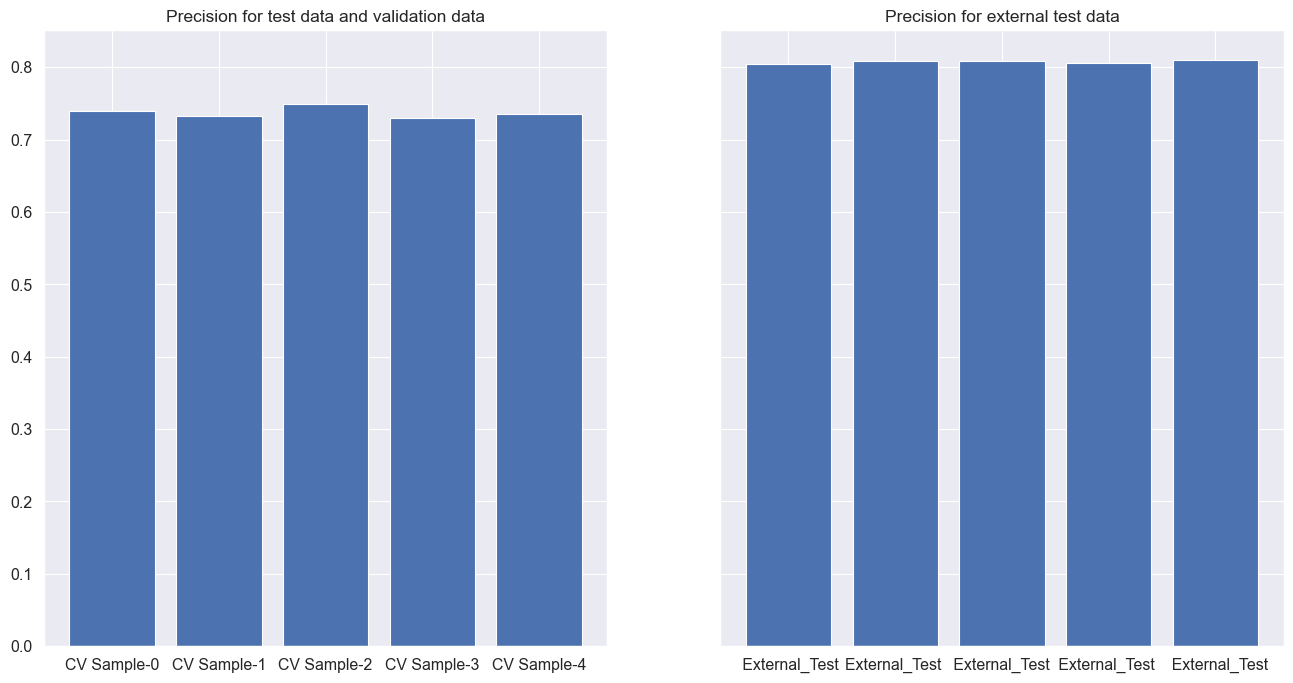

In [15]:
#initialize model
model_use = LogisticRegression(penalty='l1',n_jobs=-1,solver='liblinear')

#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = linear_features_all,
                                                                           problem_type = 'classification',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_linear,
                                                                           model = model_use,
                                                                           x_validation = x_validation_linear,
                                                                           y_validation = y_validation_linear,
                                                                           x_external = x_external_linear,
                                                                           y_external = y_external_linear,
                                                                           sequence = 'lasso')
#make plot
make_plot(metric = 'Precision',
          test_cost = test_cost,
          external_cost = external_cost)

## Ridge

Total number of input features: 819 , total number of selected features: 819
Combined precision on test and validation data is 0.5660941597853828 combined recall on test and validation data is 0.21687162193130166
Precision on external test data is 0.7649473116135401 recall on external test data is 0.2927694406548431


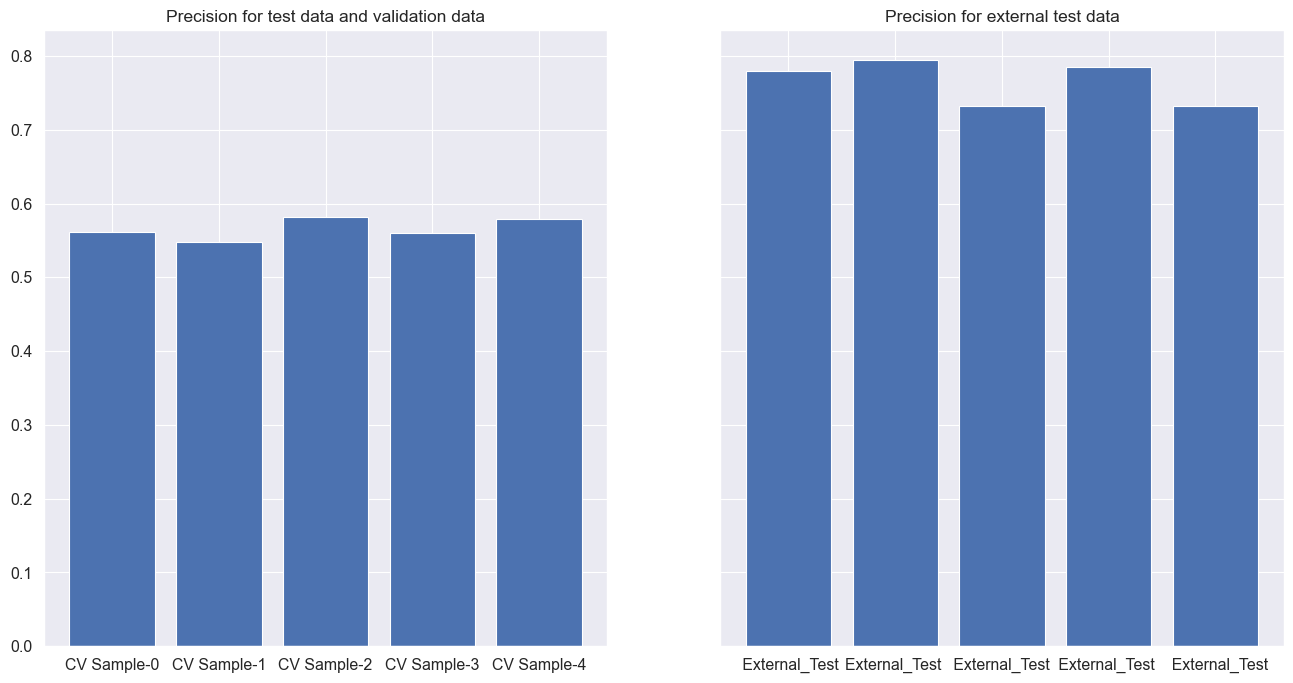

In [16]:
#initialize model
model_use = LogisticRegression(penalty='l2',n_jobs=-1,solver='liblinear')

#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = linear_features_all,
                                                                           problem_type = 'classification',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_linear,
                                                                           model = model_use,
                                                                           x_validation = x_validation_linear,
                                                                           y_validation = y_validation_linear,
                                                                           x_external = x_external_linear,
                                                                           y_external = y_external_linear,
                                                                           sequence = 'lasso')
#make plot
make_plot(metric = 'Precision',
          test_cost = test_cost,
          external_cost = external_cost)

## ElasticNet

Total number of input features: 819 , total number of selected features: 819
Combined precision on test and validation data is 0.5116348813955834 combined recall on test and validation data is 0.12210149883643293
Precision on external test data is 0.7858807165087451 recall on external test data is 0.1908140063665302


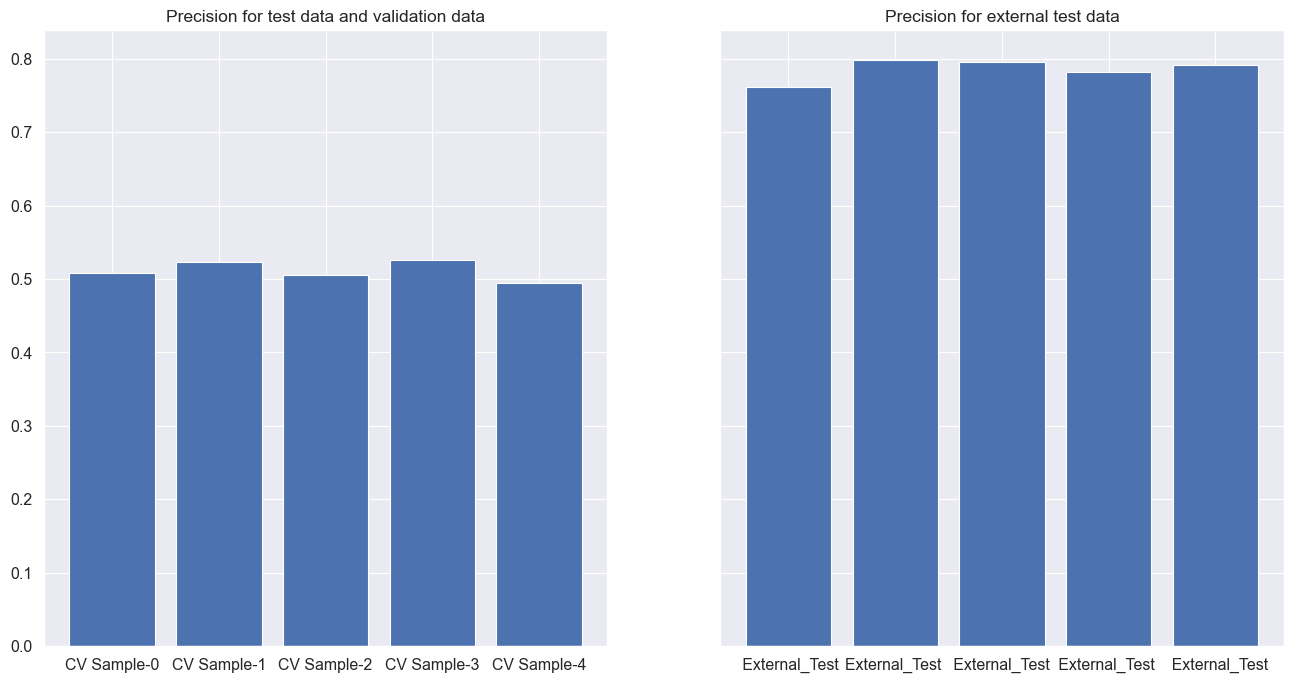

In [19]:
#initialize model
model_use = LogisticRegression(penalty='elasticnet',n_jobs=-1,solver='saga',l1_ratio=0.5)

#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = linear_features_all,
                                                                           problem_type = 'classification',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_linear,
                                                                           model = model_use,
                                                                           x_validation = x_validation_linear,
                                                                           y_validation = y_validation_linear,
                                                                           x_external = x_external_linear,
                                                                           y_external = y_external_linear,
                                                                           sequence = 'lasso')
#make plot
make_plot(metric = 'Precision',
          test_cost = test_cost,
          external_cost = external_cost)

## Tree Feature Importance - LightGBM

Total number of input features: 113 , total number of selected features: 34
Combined precision on test and validation data is 0.7982387704447285 combined recall on test and validation data is 0.7615509994694764
Precision on external test data is 0.8315920962602448 recall on external test data is 0.8331059572532971


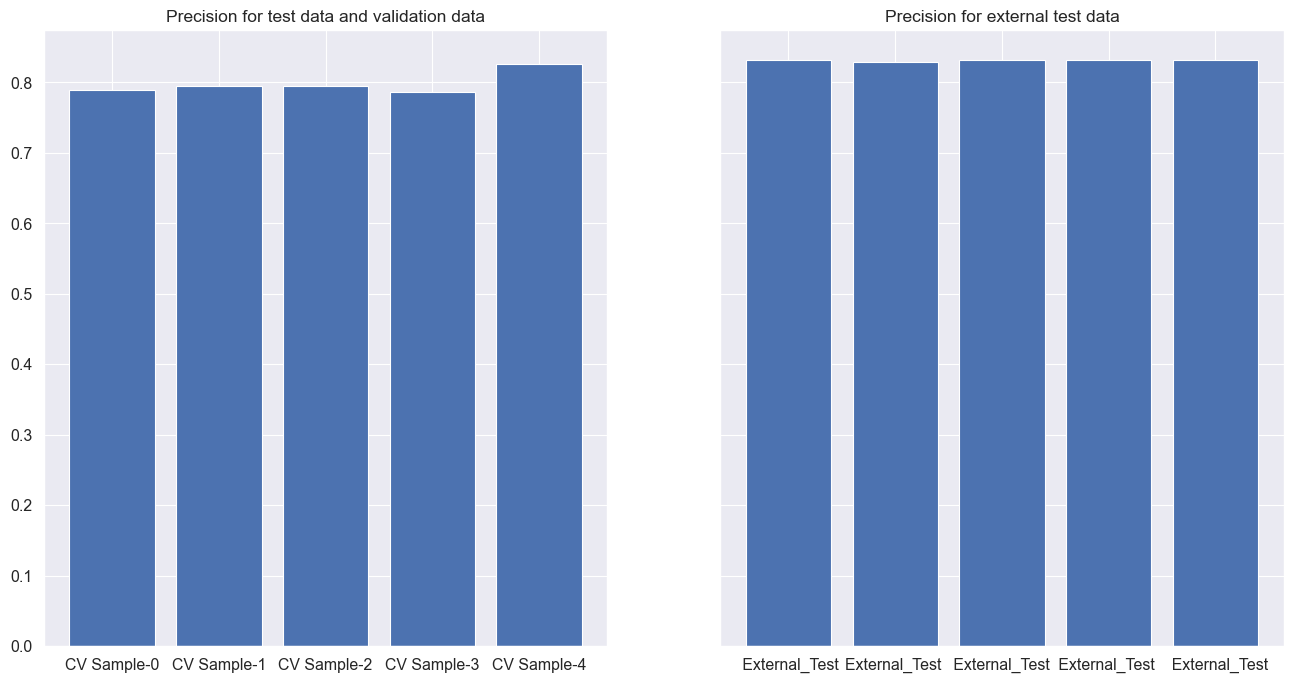

In [57]:
#initialize model
model_use = LGBMClassifier(random_state=1,n_jobs=-1,n_estimators=200)

#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = tree_features_all,
                                                                           problem_type = 'classification',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_tree,
                                                                           model = model_use,
                                                                           x_validation = x_validation_tree,
                                                                           y_validation = y_validation_tree,
                                                                           x_external = x_external_tree,
                                                                           y_external = y_external_tree,
                                                                           sequence = 'feature_importance')

#make plot
make_plot(metric = 'Precision',
          test_cost = test_cost,
          external_cost = external_cost)

## Tree Feature Importance - XGboost

Total number of input features: 113 , total number of selected features: 22
Combined precision on test and validation data is 0.8268436450937221 combined recall on test and validation data is 0.7031935539478834
Precision on external test data is 0.8662421241406575 recall on external test data is 0.6720327421555252


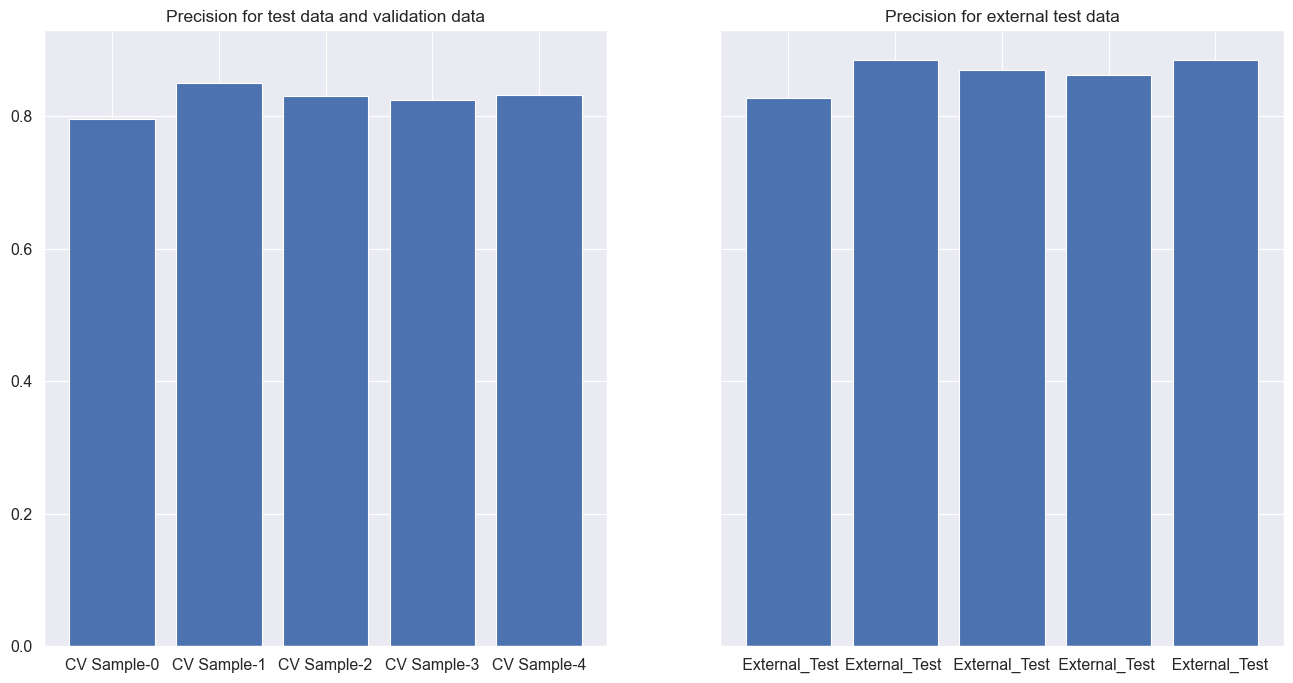

In [60]:
#initialize model
model_use = XGBClassifier(n_estimators=200,random_state=1,n_jobs=-1,tree_method = 'gpu_hist')

#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = tree_features_all,
                                                                           problem_type = 'classification',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_tree,
                                                                           model = model_use,
                                                                           x_validation = x_validation_tree,
                                                                           y_validation = y_validation_tree,
                                                                           x_external = x_external_tree,
                                                                           y_external = y_external_tree,
                                                                           sequence = 'feature_importance')

#make plot
make_plot(metric = 'Precision',
          test_cost = test_cost,
          external_cost = external_cost)

## Boruta - RandomForest

Total number of input features: 113 , total number of selected features: 9
Combined precision on test and validation data is 0.7396345908264468 combined recall on test and validation data is 0.6649111309555491
Precision on external test data is 0.7873037280009834 recall on external test data is 0.755525238744884


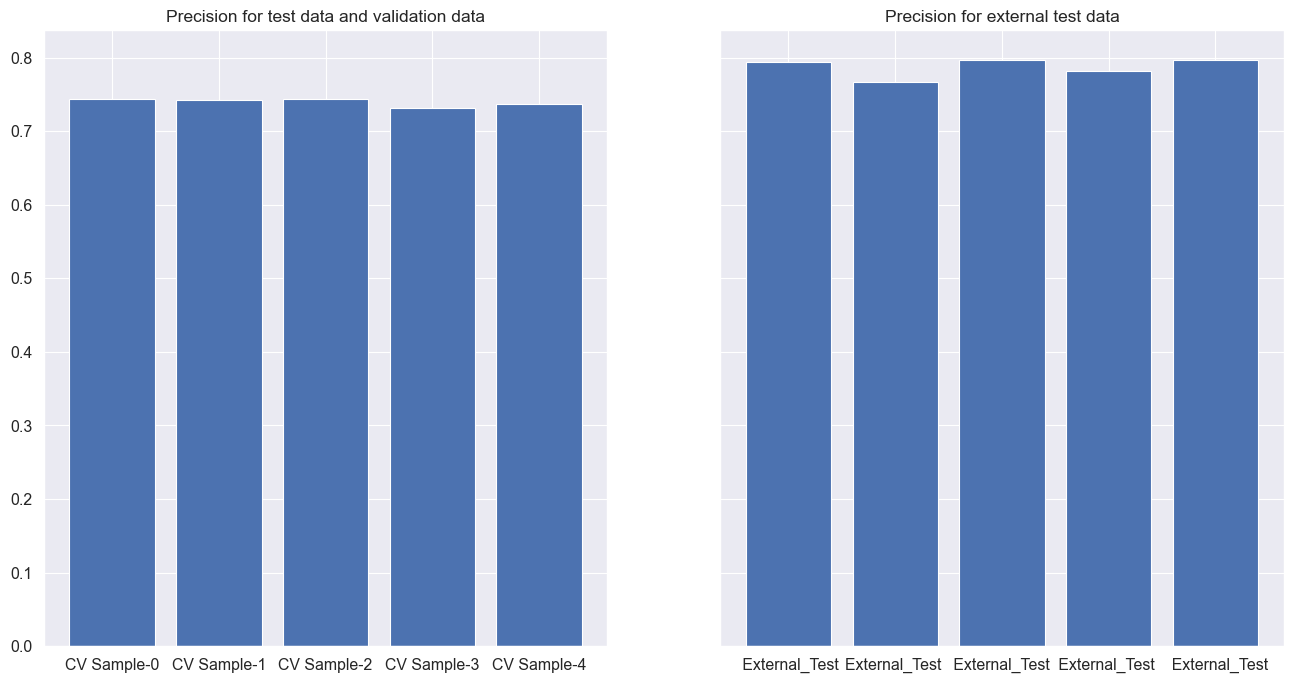

In [86]:
#initialize model
model_use = RandomForestClassifier(random_state=1,n_jobs=-1,n_estimators=200)

#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = tree_features_all,
                                                                           problem_type = 'classification',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_tree,
                                                                           model = model_use,
                                                                           x_validation = x_validation_tree,
                                                                           y_validation = y_validation_tree,
                                                                           x_external = x_external_tree,
                                                                           y_external = y_external_tree,
                                                                           sequence = 'boruta')

#make plot
make_plot(metric = 'Precision',
          test_cost = test_cost,
          external_cost = external_cost)

## Boruta - Xgboost

Total number of input features: 113 , total number of selected features: 22
Combined precision on test and validation data is 0.8345547573665197 combined recall on test and validation data is 0.6969829010897188
Precision on external test data is 0.8805770294716518 recall on external test data is 0.6355616189176898


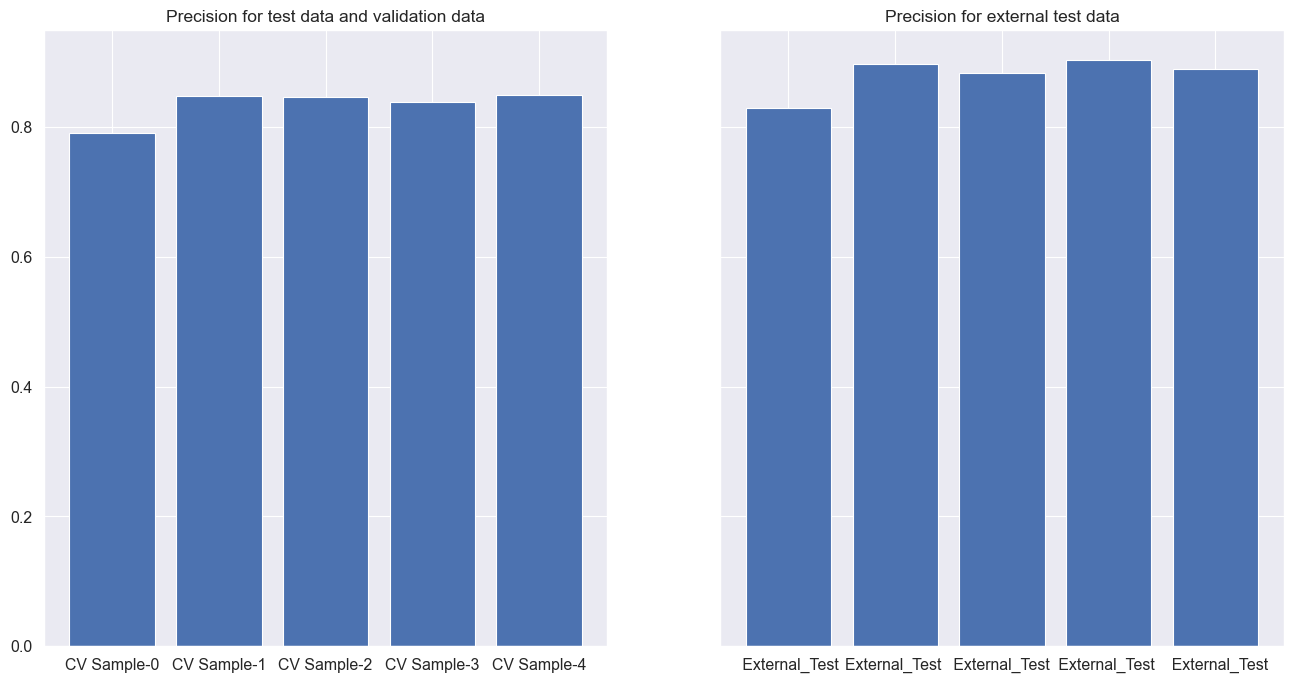

In [74]:
#initialize model
model_use = XGBClassifier(n_estimators=200,random_state=1,n_jobs=-1,tree_method = 'gpu_hist')

#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = tree_features_all,
                                                                           problem_type = 'classification',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_tree,
                                                                           model = model_use,
                                                                           x_validation = x_validation_tree,
                                                                           y_validation = y_validation_tree,
                                                                           x_external = x_external_tree,
                                                                           y_external = y_external_tree,
                                                                           sequence = 'boruta')

#make plot
make_plot(metric = 'Precision',
          test_cost = test_cost,
          external_cost = external_cost)